<a href="https://colab.research.google.com/github/21Ovi/TensorFlow_/blob/main/04_Transfer_Learning_in_TensorFlow_01_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is `leveraging` a working model's existing architecture and learned patterns for our own problem.

There are two main benifits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learneed patterns on similar data to our own, then we can adapt those patterns to our own data.

In [19]:
# Are we using a GPU?
!nvidia-smi

Mon Mar  6 16:31:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |  13063MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [20]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-03-06 16:31:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  40.7MB/s    in 4.6s    

2023-03-06 16:31:53 (35.2 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [21]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [22]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                            target_size=IMAGE_SHAPE,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be prepared during or after training, Some of the mose popular callbacls:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [23]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating model using tensorFlow Hub

In the past we've been using TensorFlow to create our own models layer by layer from scratch.

Now we're goin to do similar process, except the majority of our model's layers are going to come to TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [24]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [25]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [26]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequntial model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and sace it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Create ResNet TensorFlow Hub Feature Extraction model:

In [27]:
# Create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [28]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [29]:
# Let's fit our ResNet model to the data ( 10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230306-163157
Epoch 1/5
24/24 [==============================] - 23s 797ms/step - loss: 1.7358 - accuracy: 0.3973 - val_loss: 1.0932 - val_accuracy: 0.6496
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.8233 - accuracy: 0.7560 - val_loss: 0.8050 - val_accuracy: 0.7416
Epoch 3/5
24/24 [==============================] - 18s 771ms/step - loss: 0.5743 - accuracy: 0.8453 - val_loss: 0.7622 - val_accuracy: 0.7480
Epoch 4/5
24/24 [==============================] - 18s 786ms/step - loss: 0.4502 - accuracy: 0.8893 - val_loss: 0.6943 - val_accuracy: 0.7764
Epoch 5/5
24/24 [==============================] - 18s 760ms/step - loss: 0.3625 - accuracy: 0.9187 - val_loss: 0.6713 - val_accuracy: 0.7840


Wow! 

That is incredible. Our feature extractor model out perform ALL of the previous models we built by hand...(substantially) and in a quicker training time AND with only 10% if the training examples.

In [30]:
# Let's create s function to plot our loss curves...
# Tidbit: I could put a function into a script called "helper.py" and import it whenever needed...

import matplotlib.pyplot as plt
# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation  metrics.

  Args:
    History: TensorFlow History object
  
  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("Epochs")
  plt.legend();

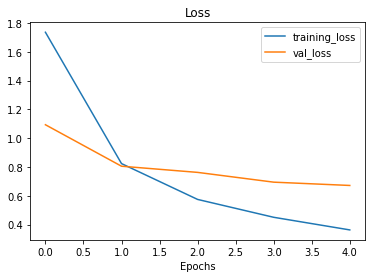

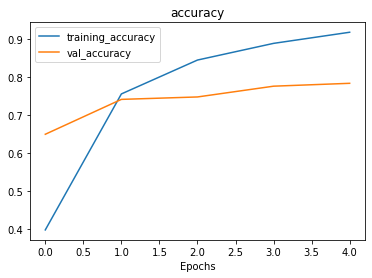

In [31]:
plot_loss_curves(resnet_history)

### Create EfficientNetB0 TensorFlow Hub Feature Extraction model:

In [14]:
# Create EfficientNetB0 feature extractor model
effecientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet Model
effecientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = effecientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow.hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow.hub/efficientnetb0/20230306-163000
Epoch 1/5
24/24 [==============================] - 31s 829ms/step - loss: 1.7793 - accuracy: 0.4760 - val_loss: 1.2521 - val_accuracy: 0.7208
Epoch 2/5
24/24 [==============================] - 17s 712ms/step - loss: 1.0265 - accuracy: 0.7707 - val_loss: 0.8578 - val_accuracy: 0.8032
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.7392 - accuracy: 0.8320 - val_loss: 0.6923 - val_accuracy: 0.8368
Epoch 4/5
24/24 [==============================] - 17s 751ms/step - loss: 0.5986 - accuracy: 0.8693 - val_loss: 0.6099 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 17s 728ms/step - loss: 0.5057 - accuracy: 0.8867 - val_loss: 0.5583 - val_accuracy: 0.8616


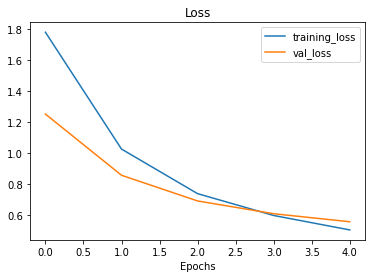

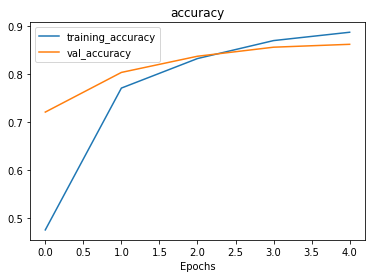

In [15]:
plot_loss_curves(efficientnet_history)

In [16]:
effecientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [18]:
# How mandy layers does our efficientnetb0 feature exctractor have?
len(effecientnet_model.layers[0].weights)

309

## Different types of transfer learning

* `"As is" transfer learning` - using existing model with no changes what so ever (e.g ImageNet model on 1000 ImageNet classes, non of your own)
* `"Feature extraction" transfer learning` - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output of your own problem (e.g 1000 classes -> 10 classes of food)
* `"Fine-tuning" transfer learning` - use the prelearned patterns of an existing model and `"fine-tune"` many or all of the underlying layers (including new output layers)

## Comparing our models resutls using TensorBoard

>🔑**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload it to TensorBoard.deb

In [32]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub Feature extraction model architecture using 10% of the training data" \
  --one_shot

2023-03-06 16:48:53.284167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 16:48:53.284276: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 16:48:53.284297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoar

Our TensorBoard experiments are uploaded publically here:  https://tensorboard.dev/experiment/iECRBqiDQSKDAPBlMiGqzQ/

In [33]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2023-03-06 16:55:30.911836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 16:55:30.911935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 16:55:30.911953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/iECRBqiDQSKDAPBlMiGqzQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub Feat

In [34]:
# Delete an experiment
# !tensorboard dev --experiment_id iECRBqiDQSKDAPBlMiGqzQ

In [35]:
# Comfirm the delettion by re-checking what experiments you have left
!tensorboard dev list

2023-03-06 16:56:48.554888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 16:56:48.554980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 16:56:48.554998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/iECRBqiDQSKDAPBlMiGqzQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub Feat